## Importing

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, MinMaxScaler
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.decomposition import PCA

from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline

## Loading data

In [2]:
def read_data(filename):
    df = pd.read_csv(filename)
    df = df.rename(columns={'spacegroup': 'sg',
                            'number_of_total_atoms': 'Natoms',
                            'percent_atom_al': 'xAl',
                            'percent_atom_ga': 'xGa',
                            'percent_atom_in': 'xIn',
                            'lattice_vector_1_ang': 'a',
                            'lattice_vector_2_ang': 'b',
                            'lattice_vector_3_ang': 'c',
                            'lattice_angle_alpha_degree': 'alpha',
                            'lattice_angle_beta_degree': 'beta',
                            'lattice_angle_gamma_degree': 'gamma',
                            'formation_energy_ev_natom': 'Ef',
                            'bandgap_energy_ev': 'Eg'})
    return df

In [3]:
train = read_data('./train.csv')
test = read_data('./test.csv')
full = [train, test] 

vector_labels = ['a', 'b', 'c']
angle_labels = ['alpha', 'beta', 'gamma']
composition_labels = ['xAl', 'xGa', 'xIn']

## Data Exploration

### Spacegroups
Check which spacegroups train and test sets contain.

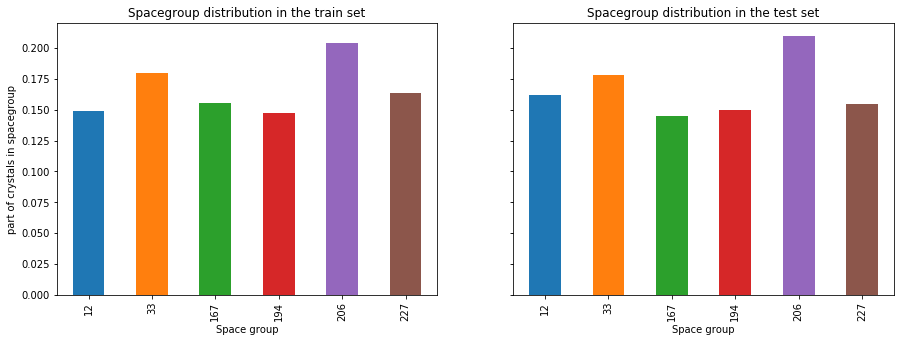

In [4]:
f, ax = plt.subplots(1, 2, sharey=True, figsize=(15, 5))
titles = [f'Spacegroup distribution in the {i} set' for i in ['train', 'test']]

for i in range(2):
    full[i]['sg'].value_counts(normalize=True).sort_index().plot.bar(ax=ax[i])
    ax[i].set_title(titles[i])
    ax[i].set_xlabel('Space group')
ax[0].set_ylabel('part of crystals in spacegroup')
plt.show()

Train and test sets have the same spacegroups.

### Number of atoms

Train set:

In [5]:
pd.crosstab(train['Natoms'], train['sg'])

sg,12,33,167,194,206,227
Natoms,,,,,,
10.0,0,0,0,13,0,0
20.0,84,0,0,0,0,0
30.0,0,0,326,0,0,0
40.0,0,126,0,0,0,393
60.0,0,0,48,0,0,0
80.0,274,306,0,340,490,0


Test set:

In [6]:
pd.crosstab(test['Natoms'], test['sg'])

sg,12,33,167,194,206,227
Natoms,,,,,,
10.0,0,0,0,7,0,0
20.0,27,0,0,0,0,0
30.0,0,0,73,0,0,0
40.0,0,30,0,0,0,93
60.0,0,0,14,0,0,0
80.0,70,77,0,83,126,0


### Lattice angles

In [7]:
train.groupby('sg')[angle_labels].describe().xs(slice('mean', 'std'), level=1, axis=1)

,alpha,alpha,beta,beta,gamma,gamma
sg,,,,,,
12,89.999838,0.000290,104.572380,0.525823,90.000112,0.000058
33,90.001709,0.002258,90.000445,0.001798,90.000840,0.000513
167,89.993366,0.004110,90.007081,0.004660,120.001058,0.000466
194,90.011335,0.006336,90.002652,0.005360,119.995280,0.005568
206,90.002605,0.001459,90.002776,0.001347,89.997340,0.001613
227,91.479187,3.009116,91.362545,3.328180,63.746595,43.309462


In [8]:
test.groupby('sg')[angle_labels].describe().xs(slice('mean', 'std'), level=1, axis=1)

,alpha,alpha,beta,beta,gamma,gamma
sg,,,,,,
12,89.999853,0.000296,104.560765,0.538130,90.000115,0.000053
33,90.001598,0.002282,90.000267,0.001955,90.000840,0.000530
167,89.993017,0.004548,90.007460,0.005040,120.001075,0.000513
194,90.010834,0.006072,90.003639,0.006037,119.996086,0.005977
206,90.002587,0.001451,90.002714,0.001352,89.997291,0.001588
227,91.043244,2.422655,90.836886,2.506604,73.757023,45.023798


All spacegroups have small deviation of angles, except 227. Also beta angle from spacegroup 12 have significant deviation. 

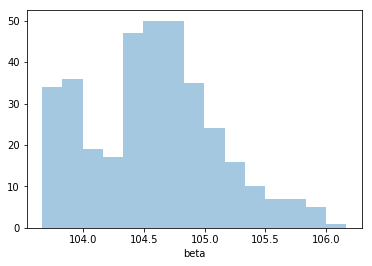

In [9]:
sns.distplot(train[train['sg']==12]['beta'], kde=False, bins=15)

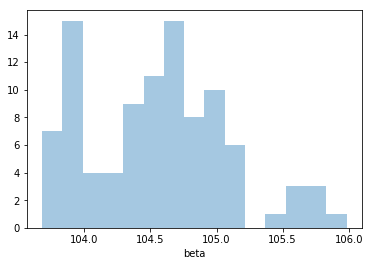

In [10]:
sns.distplot(test[test['sg']==12]['beta'], kde=False, bins=15)

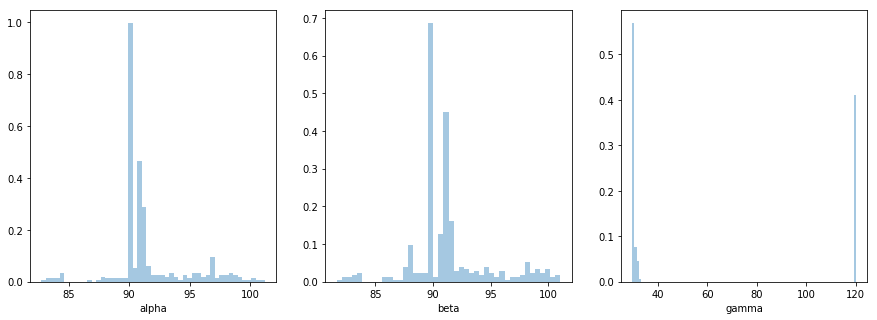

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
bins = [None, None, 100]
for i, angle in enumerate(angle_labels):
    sns.distplot(train[train['sg']==227][angle], ax=ax[i], kde=False, norm_hist=True, bins=bins[i])

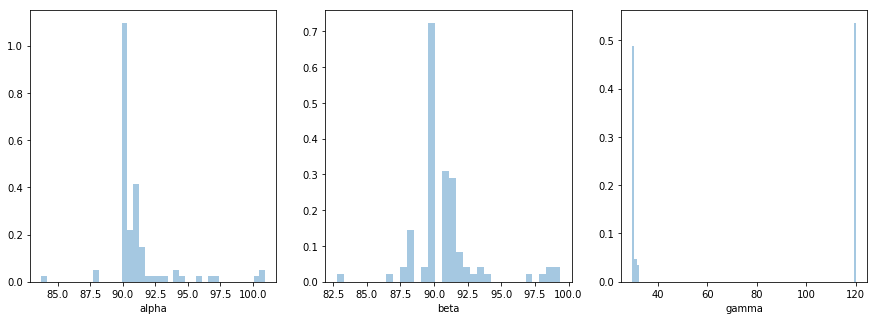

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
bins = [None, None, 100]
for i, angle in enumerate(angle_labels):
    sns.distplot(test[test['sg']==227][angle], ax=ax[i], kde=False, norm_hist=True, bins=bins[i])

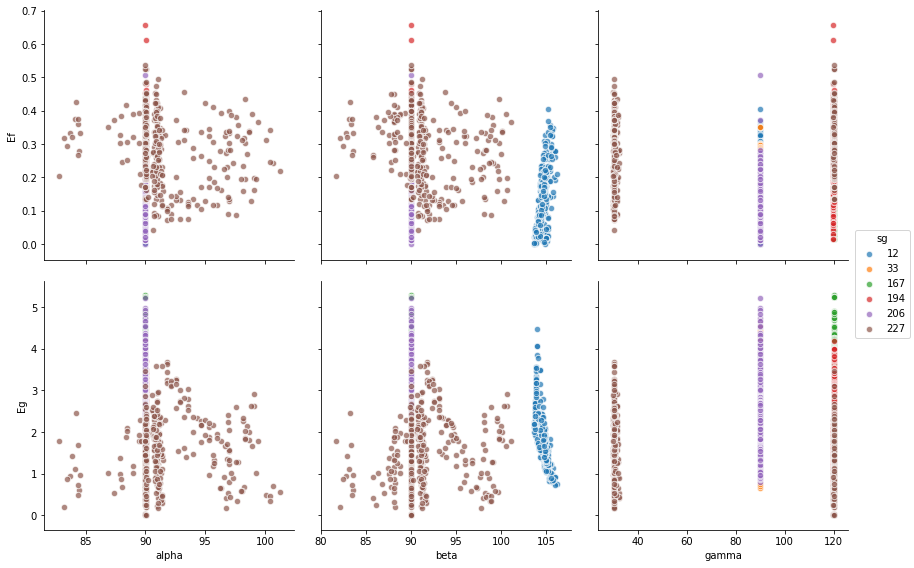

In [13]:
sns.pairplot(train, x_vars=angle_labels, y_vars=['Ef', 'Eg'], hue='sg', plot_kws={"s": 40, "alpha":0.7}, size=4)

### Lattice vectors

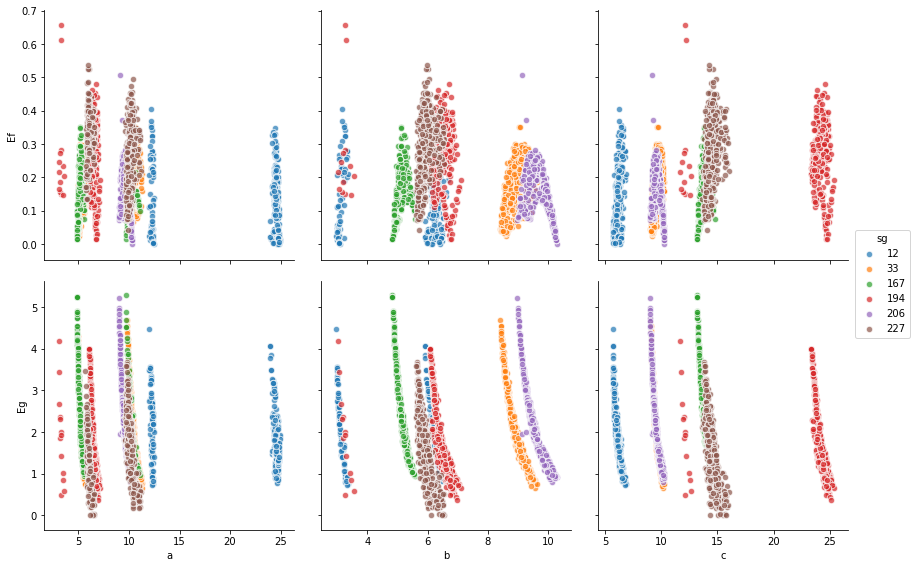

In [14]:
sns.pairplot(train, x_vars=vector_labels, y_vars=['Ef', 'Eg'], hue='sg', plot_kws={"s": 40, "alpha":0.7}, size=4)

### Composition

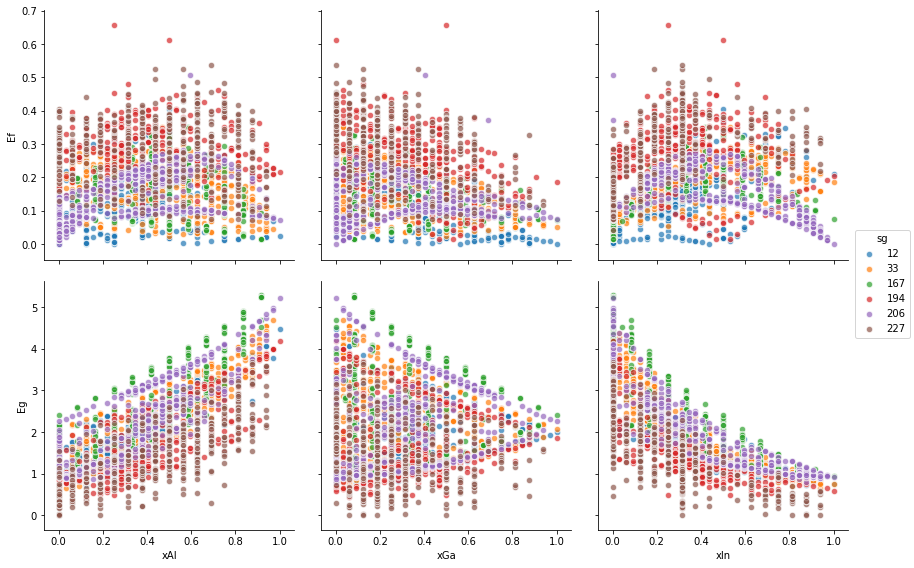

In [15]:
sns.pairplot(train, x_vars=composition_labels, y_vars=['Ef', 'Eg'], hue='sg', plot_kws={"s": 40, "alpha":0.7}, size=4)

## Feature Engineering

In [16]:
def get_geometry_features(dataset, path):
    elements = ['Al', 'Ga', 'In', 'O']
    cols = [el+str(i) for el in elements for i in range(1, 7)]

    pca = PCA(n_components=2)

    row_list = list()
    for i in dataset.id.values:
        geom = pd.read_csv(f'./{path}/{i}/geometry.xyz',
                           sep=' ',
                           skiprows=6,
                           names=['atom', 'x', 'y', 'z', 'type'])
        row = list()
        for element in elements:
            try:
                element_xyz = geom[geom['type']==element][['x', 'y', 'z']]
                reduced = pca.fit_transform(element_xyz.values.T).ravel()
            except:
    #         arr = g1[g1['type']==element][['x', 'y', 'z']].values.ravel()
    #         if arr.shape == 3:
    #             arr = np.hstack((arr, np.zeros(3)))
                reduced = np.zeros(6)
            row.append(reduced)
        row = np.array(row).ravel()
        row_list.append(row)
    return pd.DataFrame(row_list, columns=cols)

In [17]:
geometry_train = get_geometry_features(train, 'train')
geometry_test = get_geometry_features(test, 'test')

Add feature degree of tetragonality:

In [18]:
for ds in full:
    ds['tetra'] = ds['c'] / ds['a']

Degree to radian:

In [19]:
for ds in full:
    for angle in angle_labels:
        ds[angle] = np.radians(ds[angle])

Add density feature and volume:
\begin{equation}
V=abc\sqrt{1+2\cos \alpha \cos \beta \cos \gamma -\cos ^{2}\alpha - \cos^{2}\beta - \cos ^{2}\gamma }
\end{equation}

In [20]:
for ds in full:
    vector_product = ds[vector_labels].product(axis=1)
    angle_product = ds[angle_labels].apply(np.cos).product(axis=1)
    cos_angle_pow = ds[angle_labels].apply(np.cos).pow(2)
    ds['V'] = vector_product * ((1 + 2 * angle_product - (cos_angle_pow.sum(axis=1))).apply(np.sqrt))
    ds['density'] = ds['Natoms'] / ds['V']

Checking correlation map:

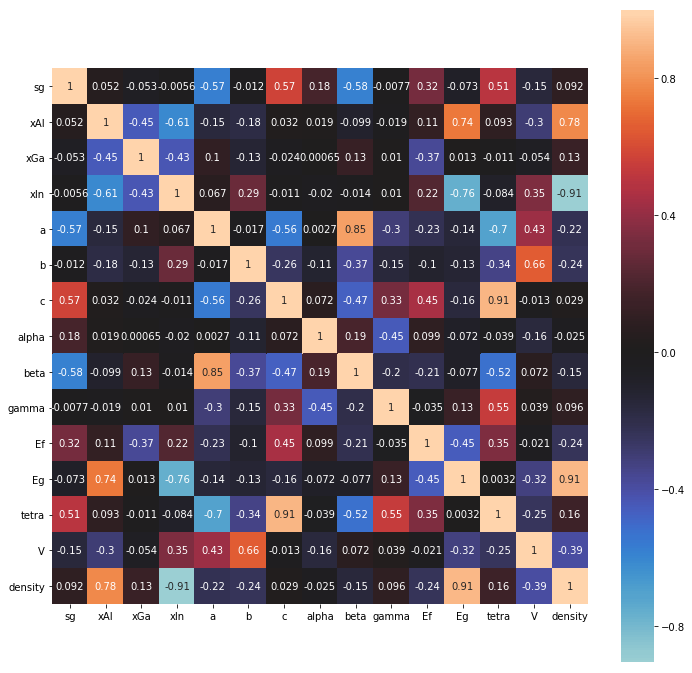

In [21]:
plt.figure(figsize=(12, 12))
sns.heatmap(train.drop(['id', 'Natoms'], axis=1).corr(), center=0, square=True, annot=True)

Check how new features relate to targets:

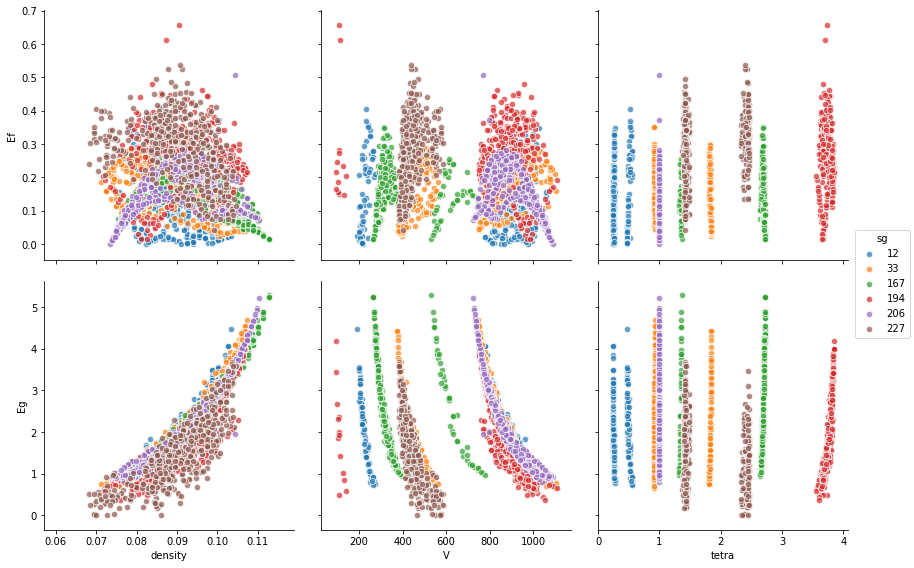

In [22]:
sns.pairplot(train, x_vars=['density', 'V', 'tetra'], y_vars=['Ef', 'Eg'], hue='sg', plot_kws={"s": 40, "alpha":0.7}, size=4)

## Building model

### Data preparing

In [88]:
# arrays for models

f_train = train.drop(labels=['Ef', 'Eg', 'id', 'Natoms', 'V'], axis=1)
g_train = train.drop(labels=['Ef', 'Eg', 'id', 'Natoms', 'V'], axis=1)
#Xarr_train = pd.concat((train.drop(labels=['Ef', 'Eg', 'id', 'Natoms', 'V'], axis=1), geometry_df), axis=1)
#Xarr_train = geometry_train

formation = train['Ef'].values
gap = train['Eg'].values

fX_train, fX_valid, fy_train, fy_valid = train_test_split(f_train.values,
                                                          train['Ef'].values,
                                                          test_size=0.15,
                                                          random_state=1337)
gX_train, gX_valid, gy_train, gy_valid = train_test_split(g_train.values,
                                                          train['Eg'].values,
                                                          test_size=0.15,
                                                          random_state=1337)

X_test = test.drop(labels=['id', 'Natoms', 'V'], axis=1).values

### Regressors

In [89]:
kr = KernelRidge()
rf = RandomForestRegressor()
br = BaggingRegressor()
gbr = GradientBoostingRegressor()
xgb = XGBRegressor()

regressors = {'KR': kr, 'RF': rf, 'BR': br, 'GBR': gbr, 'XGB': xgb}

### Hyperparameters

In [90]:
parameters = {'KR': {
                        'kernelridge__alpha': [0.001, 0.01, 0.1, 1.0],
                        'kernelridge__degree': [2],
                        'kernelridge__kernel': ['polynomial'],
                        'kernelridge__kernel_params': [{'solver': 'svd'}]
                    },
              'RF': {
                        'randomforestregressor__max_depth': [6, 7, 8],
                        'randomforestregressor__n_estimators': [120, 125, 130]
                    },
#               'ADA': {
#                         'adaboostregressor__n_estimators': [100, 120, 140, 150] , 
#                         'adaboostregressor__loss': ['linear', 'square', 'exponential'],  
#                         'adaboostregressor__learning_rate': [0.01, 0.1, 0.5, 1.0]
#                      },
              'BR': {
                        'baggingregressor__n_estimators': [50, 60, 70], 
                        'baggingregressor__max_features': [7, 8, 9],
                        'baggingregressor__max_samples': [300]
                    },
              'GBR': {
                        'gradientboostingregressor__n_estimators': [50, 70, 90, 110],
                        'gradientboostingregressor__learning_rate': [0.01, 0.1, 0.5, 1.0],
                        'gradientboostingregressor__max_depth': [3, 5, 7]
                     },
              'XGB': { 
                        'xgbregressor__max_depth': [3, 5, 7],
                        'xgbregressor__learning_rate': [0.01, 0.1, 0.5, 1.0],
                        'xgbregressor__n_estimators': [40, 50, 70],
                        #'xgbregressor__n_jobs': [dep]
                        'xgbregressor__reg_lambda': [0.1, 0.5, 0.7],
                        'xgbregressor__max_delta_step': [0.3]
                        #'xgbregressor__min_child_weight': [1,2]
                     }
             }

### Defining error and predict functions

In [91]:
def root_mean_squared_log_error(yhat, y): 
    return np.sqrt(np.square(np.log1p(yhat) - np.log1p(y)).mean())

def collect_error_score(yhat, y):
    
    mse = mean_squared_error (yhat, y)
    r2 = r2_score(yhat, y)
    rmsle = root_mean_squared_log_error(yhat, y)
    
    return (mse, r2, rmsle)

def predict_models(Xtrain, ytrain, Xvalid, yvalid, regressors):

    enc = OneHotEncoder(categorical_features=[0], sparse=False, dtype=np.float64)
    scaler = MinMaxScaler()
    
    test_error_scores = dict()
    trained_regressors = dict()
    Y_train = dict()
    
    for i, model in regressors.items():

        pipe = make_pipeline(enc, scaler, model)
        #pipe = make_pipeline(scaler, model)
        param_grid = parameters[i]
        trainedmodel = GridSearchCV(pipe,
                                    param_grid=parameters[i],
                                    cv=5,
                                    n_jobs=-1)

        trainedmodel.fit(Xtrain, ytrain)

        print(i, 'trained best score:', trainedmodel.best_score_)

        # predict test data
        ypred = trainedmodel.predict(Xvalid)
        
        # collect predicted data for feature features (lol)
        Y_train[i] = ypred

        # Get error scores on test data
        mse, r2, rmsle = collect_error_score(ypred, yvalid)
        
        test_error_scores[i] = [mse, r2, rmsle]
        trained_regressors[i] = trainedmodel
        
    # to pandas dataframes
    test_error_scores = pd.DataFrame(test_error_scores, index=['MSE', 'R2', 'RMSLE']).transpose()
    Y_train = pd.DataFrame(Y_train)
    
    return (test_error_scores, trained_regressors, Y_train)

### Prediction and Evaluation for Formation Energy

In [92]:
f_tes, f_trained_regressors, fY_train = predict_models(fX_train, fy_train, fX_valid, fy_valid, regressors)

KR trained best score: 0.816123828777
RF trained best score: 0.821088151198
BR trained best score: 0.815155603923
GBR trained best score: 0.829948884988
XGB trained best score: 0.828719788569


In [93]:
f_tes

,MSE,R2,RMSLE
BR,0.001662,0.775820,0.032929
GBR,0.001484,0.829679,0.031074
KR,0.001741,0.810995,0.033804
RF,0.001485,0.835058,0.030930
XGB,0.001523,0.815595,0.031639


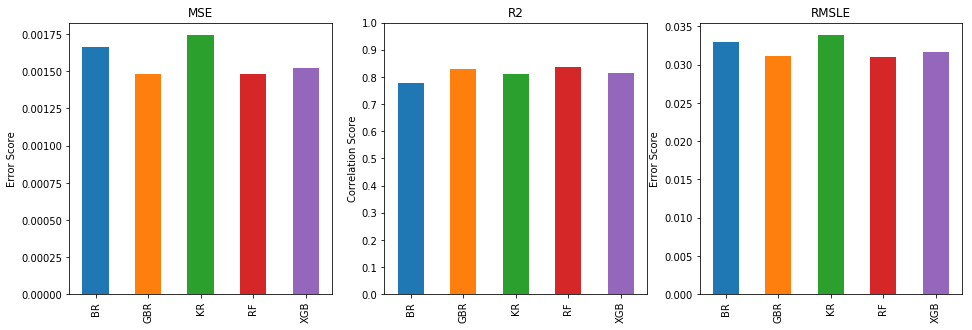

In [94]:
f, ax = plt.subplots(1, 3, figsize=(16, 5))
for i, err in enumerate(f_tes.columns):
    f_tes[err].plot.bar(ax=ax[i])
    ax[i].set_title(err)
    ax[i].set_ylabel('Error Score')
ax[1].set_ylabel('Correlation Score')
ax[1].set_yticks(np.linspace(0, 1, 11))
plt.show()

Best parameters:

In [95]:
for name, model in f_trained_regressors.items():
    print(name, ':', model.best_params_, '\n', '-'*20)

KR : {'kernelridge__alpha': 0.001, 'kernelridge__degree': 2, 'kernelridge__kernel': 'polynomial', 'kernelridge__kernel_params': {'solver': 'svd'}} 
 --------------------
RF : {'randomforestregressor__max_depth': 8, 'randomforestregressor__n_estimators': 120} 
 --------------------
BR : {'baggingregressor__max_features': 8, 'baggingregressor__max_samples': 300, 'baggingregressor__n_estimators': 70} 
 --------------------
GBR : {'gradientboostingregressor__learning_rate': 0.1, 'gradientboostingregressor__max_depth': 3, 'gradientboostingregressor__n_estimators': 90} 
 --------------------
XGB : {'xgbregressor__learning_rate': 0.1, 'xgbregressor__max_delta_step': 0.3, 'xgbregressor__max_depth': 3, 'xgbregressor__n_estimators': 70, 'xgbregressor__reg_lambda': 0.7} 
 --------------------


### Prediction and Evaluation for Band Gap Energy

In [96]:
g_tes, g_trained_regressors, gY_train = predict_models(gX_train, gy_train, gX_valid, gy_valid, regressors)

KR trained best score: 0.950256923527
RF trained best score: 0.945677748779
BR trained best score: 0.945098348316
GBR trained best score: 0.950999684225
XGB trained best score: 0.94535502005


In [97]:
g_tes

,MSE,R2,RMSLE
BR,0.053788,0.941978,0.088642
GBR,0.051737,0.947444,0.086726
KR,0.046539,0.953287,0.081155
RF,0.047459,0.951949,0.083672
XGB,0.055347,0.945143,0.090327


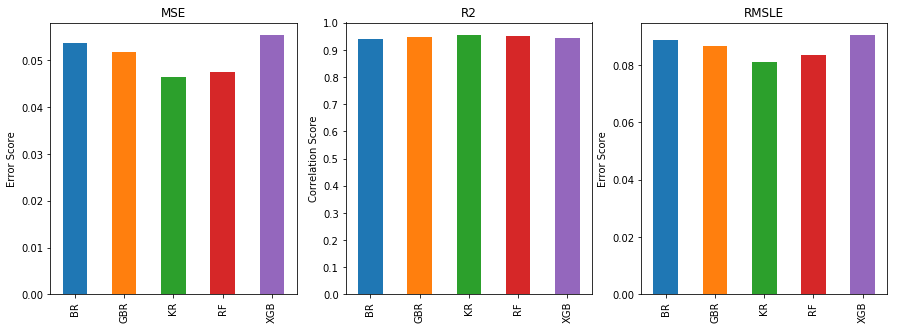

In [99]:
f, ax = plt.subplots(1, 3, figsize=(15, 5))
for i, err in enumerate(g_tes.columns):
    g_tes[err].plot.bar(ax=ax[i])
    ax[i].set_title(err)
    ax[i].set_ylabel('Error Score')
ax[1].set_ylabel('Correlation Score')
ax[1].set_yticks(np.linspace(0, 1, 11))
plt.show()

Best parameters:

In [100]:
for name, model in g_trained_regressors.items():
    print(name, ':', model.best_params_, '\n', '-'*20)

KR : {'kernelridge__alpha': 0.001, 'kernelridge__degree': 2, 'kernelridge__kernel': 'polynomial', 'kernelridge__kernel_params': {'solver': 'svd'}} 
 --------------------
RF : {'randomforestregressor__max_depth': 8, 'randomforestregressor__n_estimators': 130} 
 --------------------
BR : {'baggingregressor__max_features': 8, 'baggingregressor__max_samples': 300, 'baggingregressor__n_estimators': 50} 
 --------------------
GBR : {'gradientboostingregressor__learning_rate': 0.1, 'gradientboostingregressor__max_depth': 3, 'gradientboostingregressor__n_estimators': 90} 
 --------------------
XGB : {'xgbregressor__learning_rate': 0.5, 'xgbregressor__max_delta_step': 0.3, 'xgbregressor__max_depth': 3, 'xgbregressor__n_estimators': 50, 'xgbregressor__reg_lambda': 0.5} 
 --------------------


## Submit Prediction

In [101]:
gy_pred = g_trained_regressors['KR'].predict(X_test)
fy_pred = f_trained_regressors['XGB'].predict(X_test)

In [102]:
y_pred = np.vstack((fy_pred, gy_pred)).T
y_pred

array([[ 0.20485121,  1.5954896 ],
       [ 0.07647538,  3.76248632],
       [ 0.15550768,  3.49870156],
       ..., 
       [ 0.1646851 ,  0.69679878],
       [ 0.24875495,  2.22148677],
       [ 0.20943561,  2.16812098]])

In [103]:
submit = pd.DataFrame({'id':test['id'],
                       'formation_energy_ev_natom':y_pred[:, 0],
                       'bandgap_energy_ev':y_pred[:, 1]},
                      columns=['id', 'formation_energy_ev_natom', 'bandgap_energy_ev'])
submit.to_csv('last_conductor.csv', index=False)
submit.head()

,id,formation_energy_ev_natom,bandgap_energy_ev
0,1,0.204851,1.595490
1,2,0.076475,3.762486
2,3,0.155508,3.498702
3,4,0.028537,3.035286
4,5,0.142808,1.631391


In [104]:
!head last_conductor.csv

id,formation_energy_ev_natom,bandgap_energy_ev
1,0.2048512101173401,1.5954896000394
2,0.07647538185119629,3.7624863208679926
3,0.15550768375396729,3.498701563712075
4,0.02853715419769287,3.035286415481096
5,0.142808198928833,1.6313912974451341
6,0.09121692180633545,4.512023380269966
7,0.06511160731315613,3.2154333158287045
8,0.11443677544593811,2.0839687570137357
9,0.06119406223297119,2.6847899374852204
